# PyPI package downloads monitor

https://packaging.python.org/guides/analyzing-pypi-package-downloads/ (see also https://pepy.tech)

In [1]:
# $ pip install "pandas-gbq==0.13.2" "google-cloud-bigquery==1.25" google-auth-oauthlib pycountry

%matplotlib inline

import calendar
import datetime
import functools
import json
import logging
import pathlib

import numpy as np
import pandas as pd
import pycountry

CRED_KW = {'token', 'refresh_token', 'id_token', 'token_uri', 'client_id', 'client_secret'}

def get_credentials(scopes=('https://www.googleapis.com/auth/bigquery',), 
                    secrets=pathlib.Path('~/client_secrets.json'),
                    storage=pathlib.Path('~/storage.json')):
    secrets, storage = (path.expanduser() for path in(secrets, storage))

    def make_credentials(filename, scopes):
        from google_auth_oauthlib.flow import InstalledAppFlow

        flow = InstalledAppFlow.from_client_secrets_file(filename, scopes)
        flow.run_local_server()
        return flow.credentials

    def load_credentials(filepath, scopes):
        from google.oauth2.credentials import Credentials

        with filepath.open('rb') as f:
            kwargs = json.load(f)
        kwargs['token'] = kwargs.pop('access_token')
        kwargs = {k: v for k, v in kwargs.items() if k in CRED_KW}
        return Credentials(scopes=scopes, **kwargs)

    def save_credentials(creds, filepath):
        doc = {k: getattr(creds, k) for k in (CRED_KW - {'token'})}
        doc['access_token'] = creds.token
        with filepath.open('w') as f:
            json.dump(doc, f)

    if storage.exists():
        creds = load_credentials(storage, scopes)
    else:
        creds = None
    if creds is None:
        creds = make_credentials(secrets, scopes)
        save_credentials(creds, storage)
    return creds

PROJECT_ID = 'scripting-148608'

DEBUG =  True

if DEBUG:
    log = logging.getLogger('pandas_gbq')
    log.setLevel(logging.DEBUG)
    log.addHandler(logging.StreamHandler())

pd.set_option('display.max_rows', 100)
    
read_gbq = functools.partial(pd.read_gbq, project_id=PROJECT_ID,
                             credentials=get_credentials())

## [bigquery-public-data.pypi.file_downloads](https://console.cloud.google.com/bigquery?pli=1&p=bigquery-public-data&d=pypi&t=file_downloads&page=table)

In [2]:
MONTH = (2021, 7)

TABLE_NS = 'bigquery-public-data'

TABLE_NAME = 'pypi.file_downloads'

START = datetime.date(*MONTH, day=1)

END = datetime.date(*MONTH, day=calendar.monthrange(*MONTH)[1])

PROJECTS = ('bitsets', 'concepts', 'csv23', 'current', 'dmengine',
            'features', 'fileconfig', 'graphviz', 'gsheets', 'latexpages',
            'treedb')

INDEX = ['period',
         'project', 'version', 'type',
         'country', 'python', 'system']

QUERY = fr'''
SELECT
  FORMAT_TIMESTAMP('%Y-%m', timestamp) AS period,
  project,
  file.version AS version,
  file.type AS type,
  country_code AS country,
  REGEXP_EXTRACT(details.python, r'^\d+\.\d+') AS python,
  details.system.name AS system,
  COUNT(*) AS downloads
FROM `{TABLE_NS}.{TABLE_NAME}`
WHERE DATE(timestamp) BETWEEN DATE('{START.isoformat()}') AND DATE('{END.isoformat()}')
AND project IN {PROJECTS!r}
GROUP BY {', '.join(INDEX)}
ORDER BY {', '.join(INDEX)}
'''.strip()

RESULT = pathlib.Path('pypi_archive') / '{}-{}.csv'.format(TABLE_NAME, START.strftime('%Y-%m'))

ENCODING = 'utf-8'

if not RESULT.exists():
    if not RESULT.parent.exists():
        RESULT.parent.mkdir()
    _rf = read_gbq(QUERY)
    _rf.to_csv(RESULT, index=False, encoding=ENCODING)
    assert (_rf['downloads'] > 0).all()

(RESULT.name, RESULT.stat().st_size)

Requesting query... 
Query running...
Job ID: 46671f0e-a824-4c2b-a73d-77c7f7a1ebff
Query done.
Processed: 15.0 GB Billed: 15.0 GB
Standard price: $0.07 USD

Got 16438 rows.

Total time taken 7.66 s.
Finished at 2021-08-01 09:08:31.


('pypi.file_downloads-2021-07.csv', 753360)

In [3]:
CSV_FORMAT = {'dtype': {'period': 'string',
                        'project': 'string',
                        'version': 'string',
                        'type': 'string',
                        'country': 'string',
                        'python': 'string',
                        'system': 'string',
                        'downloads': 'uint'},
              'na_values': '', 'keep_default_na': False,
              'encoding': ENCODING}

_rf = pd.read_csv(RESULT, **CSV_FORMAT)

_rf.info(memory_usage='deep')
assert _rf.set_index(INDEX, drop=True).index.is_unique
assert _rf.sort_values(by=INDEX, na_position='first').equals(_rf)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16438 entries, 0 to 16437
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   period     16438 non-null  string
 1   project    16438 non-null  string
 2   version    16438 non-null  string
 3   type       16438 non-null  string
 4   country    15536 non-null  string
 5   python     9687 non-null   string
 6   system     8806 non-null   string
 7   downloads  16438 non-null  uint32
dtypes: string(7), uint32(1)
memory usage: 6.6 MB


In [4]:
ARCHIVES = sorted(RESULT.parent.glob(f'{TABLE_NAME}-????-??.csv'))

_cf = pd.concat((pd.read_csv(p, **CSV_FORMAT) for p in ARCHIVES),
                ignore_index=True, copy=False)

_cf.info(memory_usage='deep')
assert _cf.set_index(INDEX, drop=True).index.is_unique
assert _cf.sort_values(by=INDEX, na_position='first').equals(_cf)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605222 entries, 0 to 605221
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   period     605222 non-null  string
 1   project    605222 non-null  string
 2   version    605222 non-null  string
 3   type       605222 non-null  string
 4   country    573970 non-null  string
 5   python     307489 non-null  string
 6   system     284935 non-null  string
 7   downloads  605222 non-null  uint32
dtypes: string(7), uint32(1)
memory usage: 242.2 MB


In [5]:
PROJECT = pd.CategoricalDtype(PROJECTS, ordered=True)

TYPE = pd.CategoricalDtype(['sdist', 'bdist_wheel'], ordered=True)

COUNTRY = pd.CategoricalDtype([c.alpha_2 for c in pycountry.countries], ordered=True)

PYTHON = pd.CategoricalDtype(['1.17',
                              '2.0', '2.1', '2.2', '2.3', '2.4', '2.5', '2.6', '2.7',
                              '3.0', '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '3.10', '3.11',
                              '4.0',
                              'N/A'], ordered=True)

PYTHON_MAJOR = pd.CategoricalDtype(['1', '2', '3', '4'], ordered=True)

SYSTEM = pd.CategoricalDtype(['Linux', 'Windows', 'Darwin', 'FreeBSD', 'N/A'], ordered=True)

df = (_cf.assign(period=lambda x: pd.to_datetime(x['period']).dt.to_period(freq='M'))
      .set_index('period', drop=True)
      .fillna('N/A'))

VERSIONS = sorted(df['version'].unique(), key=lambda x: x.split('.'))

df['project'] = df['project'].astype(PROJECT)
df['version'] = df['version'].astype('category').cat.reorder_categories(VERSIONS, ordered=True)
df['type'] = df['type'].astype(TYPE)
df['country'] = df['country'].astype(COUNTRY)
df['python'] = df['python'].astype(PYTHON)
df['system'] = df['system'].astype(SYSTEM)

df.insert(df.columns.tolist().index('python') + 1,
          'python_major',
          df['python'].str.extract(r'^(\d+)', expand=False).astype(PYTHON_MAJOR))

# ignore treedb 0.0.6 downloads
assert df['downloads'].all()
df.loc[((df['project'] == 'treedb') & (df['version']  == '0.0.6')), 'downloads'] = 0
assert not df['downloads'].all()
assert df['downloads'].any()

df.info(memory_usage='deep')
df.head()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 605222 entries, 2016-05 to 2021-07
Freq: M
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   project       605222 non-null  category
 1   version       605222 non-null  category
 2   type          605222 non-null  category
 3   country       567037 non-null  category
 4   python        605221 non-null  category
 5   python_major  307488 non-null  category
 6   system        603527 non-null  category
 7   downloads     605222 non-null  uint32  
dtypes: category(7), uint32(1)
memory usage: 11.6 MB


,project,version,type,country,python,python_major,system,downloads
period,,,,,,,,
2016-05,bitsets,0.1,sdist,AU,N/A,NaN,N/A,1
2016-05,bitsets,0.1,sdist,CA,N/A,NaN,N/A,1
2016-05,bitsets,0.1,sdist,CN,N/A,NaN,N/A,4
2016-05,bitsets,0.1,sdist,CZ,N/A,NaN,N/A,1
2016-05,bitsets,0.1,sdist,DE,N/A,NaN,N/A,1


In [6]:
(df.describe(include='all')
 .fillna(0)
 .astype(int, errors='ignore')
 .replace(0, ''))

,project,version,type,country,python,python_major,system,downloads
count,605222,605222,605222,567037,605221,307488,603527,605222
unique,11,115,2,223,17,3,5,
top,graphviz,0.8.4,bdist_wheel,US,N/A,3,N/A,
freq,325418,36063,395594,43025,297733,240682,320287,
mean,,,,,,,,150
std,,,,,,,,6684
min,,,,,,,,
25%,,,,,,,,1
50%,,,,,,,,2
75%,,,,,,,,5


In [7]:
(df.resample('Y')
 .agg({'downloads': ['sum',
                     'count', 'nunique', 'min', pd.Series.mode, 'median', 'max',
                     'mean', 'std',                     
                     'first', 'last']}))

downloads                                                       \
             sum   count nunique min mode median      max        mean   
period                                                                  
2016      335323   37412     340   0    1    2.0     4694    8.962980   
2017     1185394   74034     619   0    1    2.0    59500   16.011481   
2018     3746626   91892     978   0    1    2.0   111462   40.772059   
2019    13936296  134371    1719   0    1    2.0   253337  103.715058   
2020    33732913  162403    2520   0    1    2.0   896057  207.711144   
2021    37895023  105110    2061   1    1    2.0  1539371  360.527286   

                                 
                 std first last  
period                           
2016       73.018982     1    0  
2017      419.026124     7    0  
2018     1201.764917     4    0  
2019     2763.576785     2   78  
2020     6245.382454     3    1  
2021    13630.621800     2   58

In [8]:
(df.pivot_table(values='downloads', index='project', aggfunc='sum', margins=True)
 .assign(ratio=lambda x: x['downloads'] / x['downloads'].sum() * 2)
 .style.format({'downloads': '{:_d}', 'ratio': '{:.1%}'})
 .set_uuid('12'))

,downloads,ratio
project,,
bitsets,226_119,0.2%
concepts,215_336,0.2%
csv23,463_896,0.5%
current,52_065,0.1%
dmengine,72_019,0.1%
features,136_810,0.2%
fileconfig,118_401,0.1%
graphviz,88_793_210,97.8%
gsheets,586_307,0.6%


In [9]:
df.pivot_table(values='downloads', index='period', columns='project', aggfunc='sum')

project,bitsets,concepts,csv23,current,dmengine,features,fileconfig,graphviz,gsheets,latexpages,treedb
period,,,,,,,,,,,
2016-05,1138,1180,0,202,392,698,418,7691,0,769,0
2016-06,3805,3799,0,654,1244,2286,1360,23462,0,2327,0
2016-07,3905,3999,0,974,1413,2407,1532,27466,0,2175,0
2016-08,4494,4505,0,1099,1737,2790,1751,27825,0,2459,0
2016-09,3989,4158,0,1169,1658,2559,1636,34277,0,4306,0
2016-10,3156,3002,0,776,1159,1912,1227,31108,0,1843,0
2016-11,3376,3505,0,622,1133,2040,1188,32904,526,1971,0
2016-12,2811,2873,0,505,931,1698,1011,36357,278,1703,0
2017-01,3145,3099,0,532,866,1571,940,47077,198,1464,0


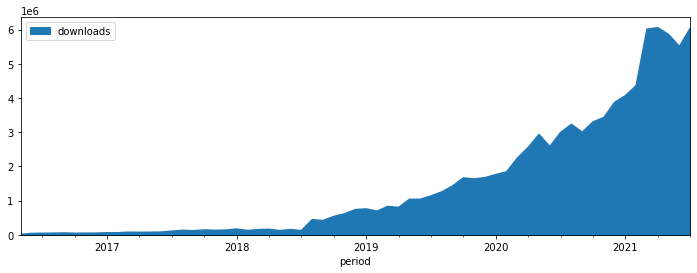

In [10]:
PLOT_FORMAT = {'figsize': (12, 4)}

(df.pivot_table(values='downloads', index='period', aggfunc='sum')
 .plot.area(**PLOT_FORMAT));

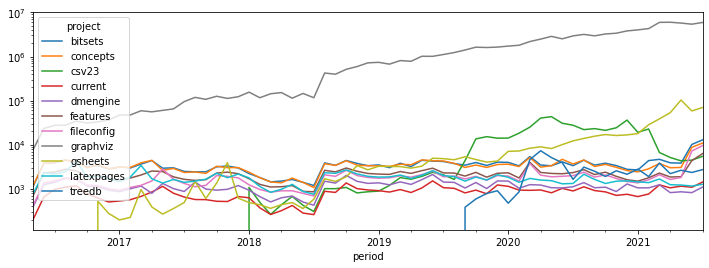

In [11]:
(df.pivot_table(values='downloads', index='period', columns='project', aggfunc='sum')
 .plot(logy=True, **PLOT_FORMAT));

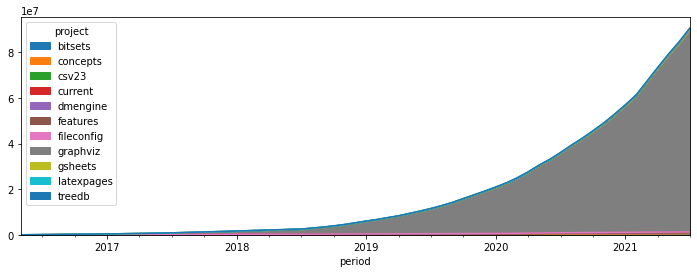

In [12]:
(df.pivot_table(values='downloads', index='period', columns='project', aggfunc='sum')
 .cumsum().plot.area(**PLOT_FORMAT));

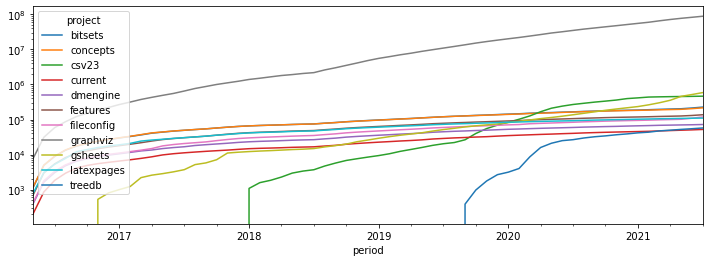

In [13]:
(df.pivot_table(values='downloads', index='period', columns='project', aggfunc='sum')
 .cumsum().plot(logy=True, **PLOT_FORMAT));

In [14]:
(df.pivot_table(values='downloads', index='python', aggfunc='sum', margins=True)
 [lambda x: x['downloads'] > 1_000]
 .sort_values(by='downloads', ascending=False)
 .assign(ratio=lambda x: x['downloads'] / x['downloads'].sum() * 2)
 .style.format({'downloads': '{:_d}', 'ratio': '{:.2%}'})
 .set_uuid('6')) 

,downloads,ratio
python,,
All,90_831_574,100.00%
3.7,38_452_816,42.33%
3.6,21_573_386,23.75%
2.7,15_626_508,17.20%
3.8,5_503_835,6.06%
3.5,5_363_308,5.90%
N/A,3_468_830,3.82%
3.9,650_584,0.72%
3.4,174_004,0.19%


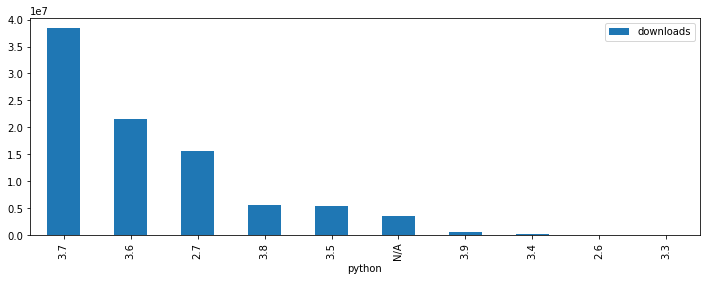

In [15]:
(df.pivot_table(values='downloads', index='python', aggfunc='sum')
 .sort_values(by='downloads', ascending=False)
 .head(10)
 .plot.bar(**PLOT_FORMAT));

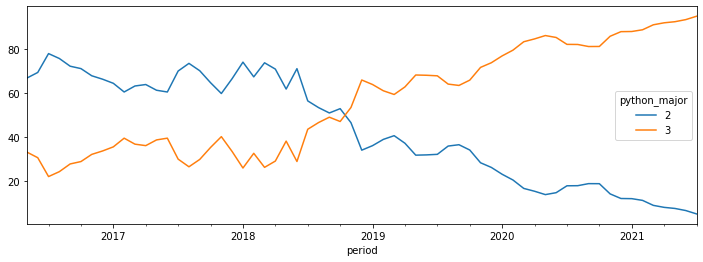

In [16]:
(df.pivot_table(values='downloads', index='period', columns='python_major', aggfunc='sum')
 .stack(level='python_major')
 [lambda x: x > 1_000]
 .transform(lambda x: 100 * x / x.groupby(level='period').sum())
 .unstack(level='python_major')
 .plot(**PLOT_FORMAT));

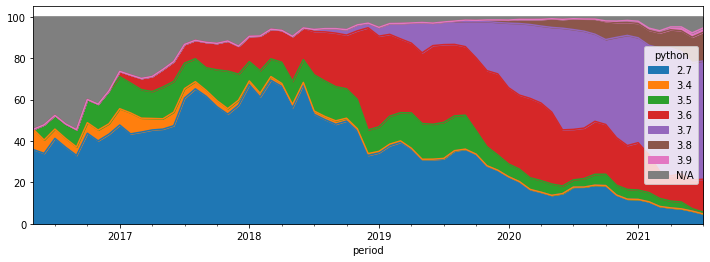

In [17]:
(df.pivot_table(values='downloads', index='period', columns='python', aggfunc='sum')
 .stack(level='python')
 [lambda x: x > 1_000]
 .transform(lambda x: 100 * x / x.groupby(level='period').sum())
 .unstack(level='python')
 .sort_values(axis='columns', by='python')
 .plot.area(**PLOT_FORMAT));

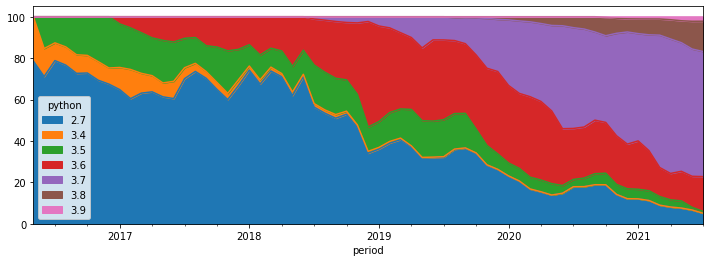

In [18]:
(df.pivot_table(values='downloads', index='period', columns='python', aggfunc='sum')
 .drop('N/A', axis='columns')
 .stack(level='python')
 [lambda x: x > 1_000]
 .transform(lambda x: 100 * x / x.groupby(level='period').sum())
 .unstack(level='python')
 .plot.area(**PLOT_FORMAT));

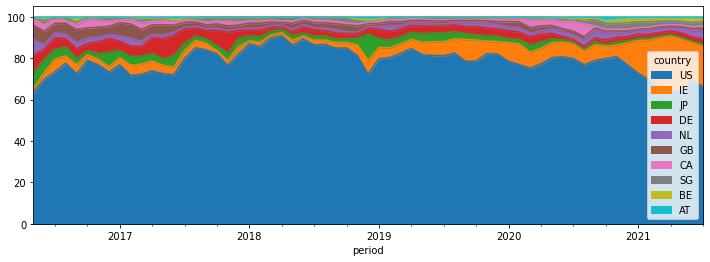

In [19]:
(df.pivot_table(values='downloads', index='period', columns='country', aggfunc='sum')
 .stack(level='country')
 .groupby('country')
 .filter(lambda g: (g > 60_000).any())
 .transform(lambda x: 100 * x / x.groupby(level='period').sum())
 .sort_values(ascending=False)
 .unstack(level='country')
 .plot.area(**PLOT_FORMAT));

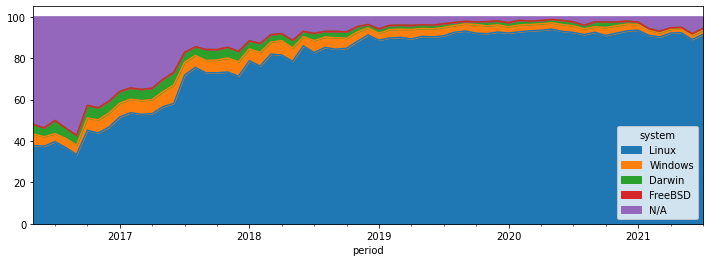

In [20]:
(df.pivot_table(values='downloads', index='period', columns='system', aggfunc='sum')
 .stack(level='system')
 .transform(lambda x: 100 * x / x.groupby(level='period').sum())
 .unstack(level='system')
 .plot.area(**PLOT_FORMAT));

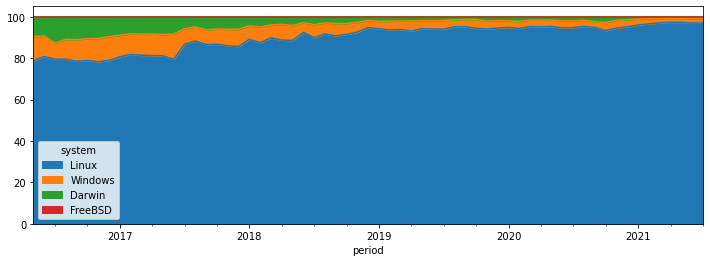

In [21]:
(df.pivot_table(values='downloads', index='period', columns='system', aggfunc='sum')
 .drop('N/A', axis='columns')
 .stack(level='system')
 .transform(lambda x: 100 * x / x.groupby(level='period').sum())
 .unstack(level='system')
 .plot.area(**PLOT_FORMAT));

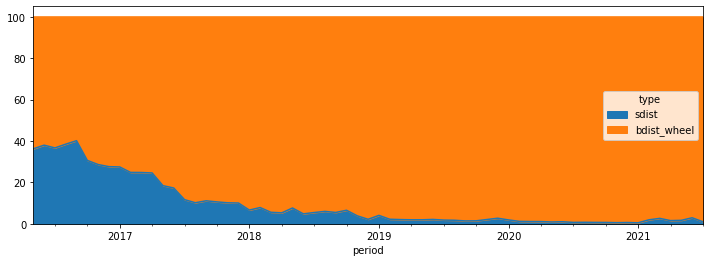

In [22]:
(df.pivot_table(values='downloads', index='period', columns='type', aggfunc='sum')
 .stack(level='type')
 .transform(lambda x: 100 * x / x.groupby(level='period').sum())
 .unstack(level='type')
 .plot.area(**PLOT_FORMAT));

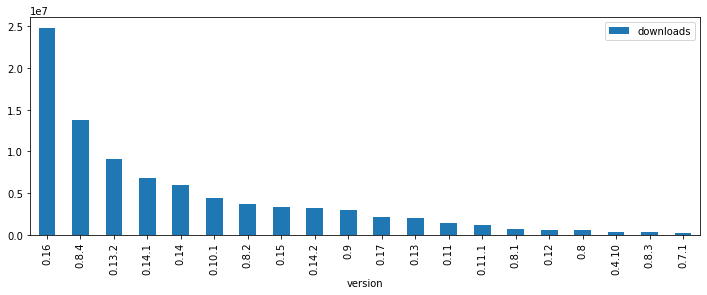

In [23]:
(df[df['project'] == 'graphviz']
 .pivot_table(values='downloads', index='version', aggfunc='sum')
 .sort_values(by='downloads', ascending=False)
 .head(20)
 .plot.bar(**PLOT_FORMAT));

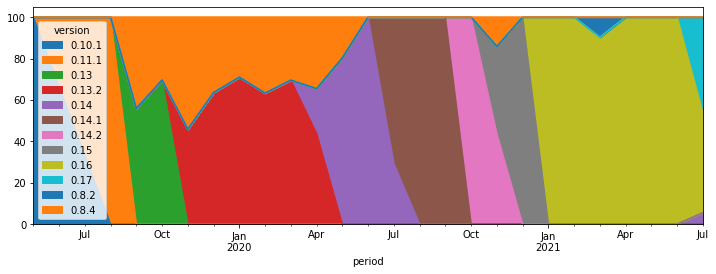

In [24]:
(df[(df['project'] == 'graphviz') & (df['downloads'] > 160_000)]
 .assign(version=lambda x: x['version'].cat.remove_unused_categories())
 .pivot_table(values='downloads', index='period', columns='version', aggfunc='sum')
 .stack(level='version')
 [lambda x: x > 0]
 .transform(lambda x: 100 * x / x.groupby(level='period').sum())
 .unstack(level='version')
 .plot.area(**PLOT_FORMAT));

In [25]:
(df[(df['project'] == 'graphviz')]
 .reset_index(level='period')
 .groupby('version')
 .agg({'period': 'first', 'downloads': 'sum'})
 .assign(ratio=lambda x: (x['downloads'] / x['downloads'].sum() * 2).map('{:.1%}'.format))
 .reset_index()
 .dropna()
 .set_index('period')
 .sort_values(by=['period', 'version'])
 ['2016-06':])

,version,downloads,ratio
period,,,
2016-09,0.5,9090,0.0%
2016-09,0.5.1,152191,0.3%
2016-12,0.5.2,185660,0.4%
2017-03,0.6,139385,0.3%
2017-04,0.7,65705,0.1%
2017-05,0.7.1,193980,0.4%
2017-07,0.8,535066,1.2%
2017-10,0.8.1,754686,1.7%
2017-12,0.8.2,3729943,8.4%
